In [1]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure seaborn for better visuals
sns.set(style='whitegrid')


In [2]:
# Step 2: Load the dataset
df = pd.read_excel('../data/Online_Retail.xlsx')

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Step 3: Check basic info about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Step 4: Check for missing values in each column
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# Step 5: Clean the data

# Drop rows with missing CustomerID (required for churn prediction)
df = df.dropna(subset=['CustomerID'])

# Remove negative or zero quantity and unit price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Check new shape
df.shape


(397884, 8)

In [6]:
# Step 6: Create TotalPrice = Quantity × UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Preview a few columns
df[['InvoiceNo', 'CustomerID', 'Quantity', 'UnitPrice', 'TotalPrice']].head()


,InvoiceNo,CustomerID,Quantity,UnitPrice,TotalPrice
0,536365,17850.0,6,2.55,15.30
1,536365,17850.0,6,3.39,20.34
2,536365,17850.0,8,2.75,22.00
3,536365,17850.0,6,3.39,20.34
4,536365,17850.0,6,3.39,20.34


In [7]:
# Step 7: Convert InvoiceDate to datetime (if not already)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Set snapshot date as one day after the last invoice date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date)


Snapshot date: 2011-12-10 12:50:00


In [8]:
# Step 8: RFM feature engineering
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# Show sample
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [9]:
# Step 9: Define churn label
rfm['Churned'] = (rfm['Recency'] > 180).astype(int)

# Check class distribution
rfm['Churned'].value_counts()


Churned
0    3478
1     860
Name: count, dtype: int64

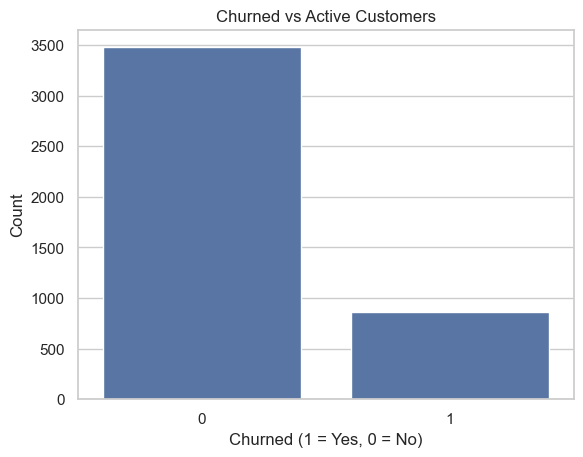

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=rfm, x='Churned')
plt.title("Churned vs Active Customers")
plt.xlabel("Churned (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()


In [11]:
# Step 10: Save processed RFM dataset
rfm.to_csv('../data/rfm_churn_data.csv')

# Confirm saved
print("Saved RFM data to ../data/rfm_churn_data.csv")


Saved RFM data to ../data/rfm_churn_data.csv
